In [2]:
import yfinance as yf
from sklearn.preprocessing import StandardScaler
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import statsmodels.api as sm
from datetime import datetime, timedelta
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.optimize import minimize
from pmdarima import auto_arima
from sklearn.metrics import mean_absolute_error, mean_squared_error

# For portfolio optimization
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt import risk_models, expected_returns, EfficientFrontier

In [3]:
# Set plot styles
plt.style.use('ggplot')
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (14, 8)
plt.rcParams['font.size'] = 14
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

## Extract historical financial data using YFinanc

In [4]:
# Extract historical financial data
assets=["SPY","TSLA","BND"]

start_date="2015-07-01"
end_date="2025-07-31"

data=yf.download(assets,start_date,end_date)
data.head()




[*********************100%***********************]  3 of 3 completed


Price           Close                              High              \
Ticker            BND         SPY       TSLA        BND         SPY   
Date                                                                  
2015-07-01  60.816730  174.917084  17.943333  60.914456  175.363859   
2015-07-02  60.967075  174.756943  18.667999  61.027217  175.566203   
2015-07-06  61.177593  174.259613  18.648001  61.222702  175.043573   
2015-07-07  61.237701  175.355499  17.858667  61.470743  175.481940   
2015-07-08  61.410622  172.413513  16.997334  61.463244  174.293342   

Price                        Low                              Open  \
Ticker           TSLA        BND         SPY       TSLA        BND   
Date                                                                 
2015-07-01  18.174667  60.764108  174.124686  17.856667  60.794179   
2015-07-02  18.830000  60.937005  174.335456  18.220667  60.937005   
2015-07-06  18.779333  61.057316  173.256472  18.420000  61.222702   
2015-07-07  18.346666  61.237701  172.059467  17.384666  61.410607   
2015-07-08  17.386667  61.312890  172.177481  16.954000  61.373032   

Price                               Volume                        
Ticker             SPY       TSLA      BND        SPY       TSLA  
Date                                                              
2015-07-01  175.110964  18.073999  5399300  135979900   31518000  
2015-07-02  175.397611  18.680000  1060100  104373700  107458500  
2015-07-06  173.458790  18.591999  2210700  117975400   61828500  
2015-07-07  174.461949  18.333332  4183200  173820200   91576500  
2015-07-08  174.006734  17.288000  1967800  164020100   93316500

## Data cleaning and Understanding.

In [5]:
# Check basic statistics
print(data.describe())
# check the datatypes of columns
print(data.dtypes)
# check missig value
print(data.isnull().sum())
if data.isnull().sum().any():
    data=data.interpolate(method="time")
# standardaization for the datasets
scaler=StandardScaler()
sdata=scaler.fit_transform(data)

Price         Close                                   High               \
Ticker          BND          SPY         TSLA          BND          SPY   
count   2535.000000  2535.000000  2535.000000  2535.000000  2535.000000   
mean      68.469188   334.193732   131.963002    68.571174   335.981618   
std        4.554602   126.427704   120.914904     4.563590   127.053089   
min       60.779175   155.869781     9.578000    60.899458   156.926762   
25%       64.654346   230.083176    18.967667    64.731238   234.024893   
50%       67.604874   305.264374    94.571335    67.749361   306.143473   
75%       71.891129   420.350494   236.761665    72.018943   423.114882   
max       77.318268   637.099976   479.859985    77.413284   638.669983   

Price                        Low                                   Open  \
Ticker         TSLA          BND          SPY         TSLA          BND   
count   2535.000000  2535.000000  2535.000000  2535.000000  2535.000000   
mean     134.960429    6

## Conduct Exploratory Data Analysis (EDA)

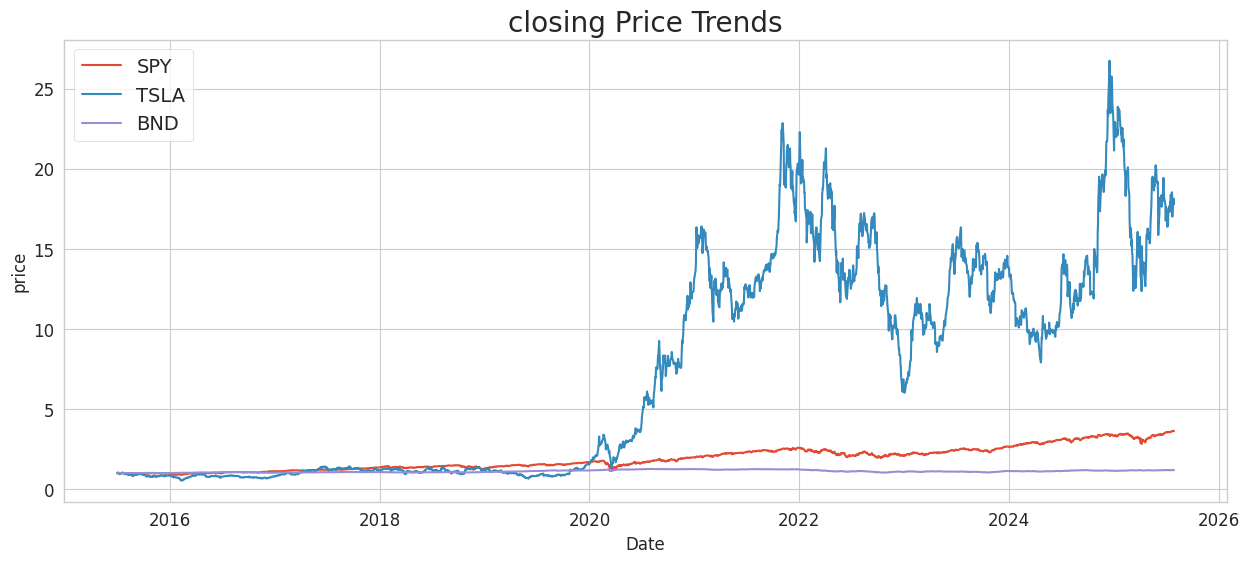

In [6]:
# Visualize the closing price over time
prices=data["Close"].copy()

plt.figure(figsize=(15,6))
for asset in assets:
  plt.plot(prices.index,prices[asset]/(prices[asset].iloc[0]),label=asset)
  plt.title("closing Price Trends")
  plt.xlabel("Date")
  plt.ylabel("price")
  plt.legend()

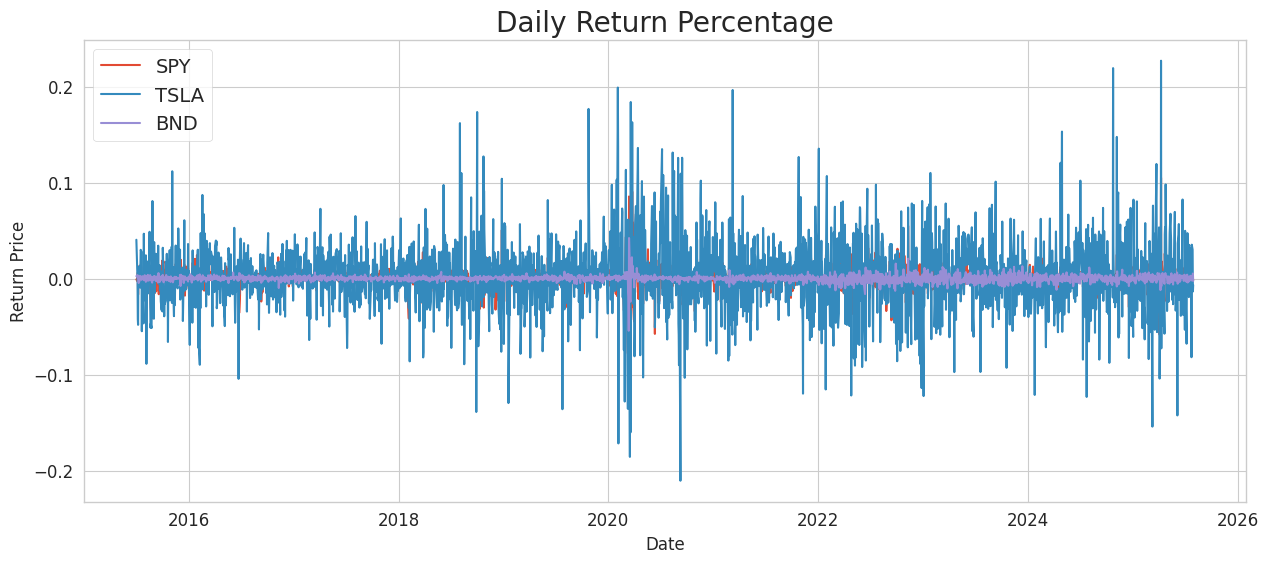

In [7]:
# Calculate and plot the daily percentage change to observe volatility.
returns=prices.pct_change().dropna()
plt.figure(figsize=(15,6))
for asset in assets:
  plt.plot(returns.index,returns[asset],label=asset)
  plt.title("Daily Return Percentage")
  plt.xlabel("Date")
  plt.ylabel("Return Price")
  plt.legend()

Ticker           BND       SPY      TSLA
Date                                    
2015-07-02       NaN       NaN       NaN
2015-07-06       NaN       NaN       NaN
2015-07-07       NaN       NaN       NaN
2015-07-08       NaN       NaN       NaN
2015-07-09       NaN       NaN       NaN
...              ...       ...       ...
2025-07-24  0.000168  0.000664  0.001825
2025-07-25  0.000178  0.000687  0.002046
2025-07-28  0.000183  0.000776  0.002655
2025-07-29  0.000194  0.000786  0.002523
2025-07-30  0.000168  0.000736  0.002504

[2534 rows x 3 columns]
Ticker           BND       SPY      TSLA
Date                                    
2015-07-02       NaN       NaN       NaN
2015-07-06       NaN       NaN       NaN
2015-07-07       NaN       NaN       NaN
2015-07-08       NaN       NaN       NaN
2015-07-09       NaN       NaN       NaN
...              ...       ...       ...
2025-07-24  0.003235  0.012831  0.046408
2025-07-25  0.003238  0.012833  0.046435
2025-07-28  0.003234  0.012748  

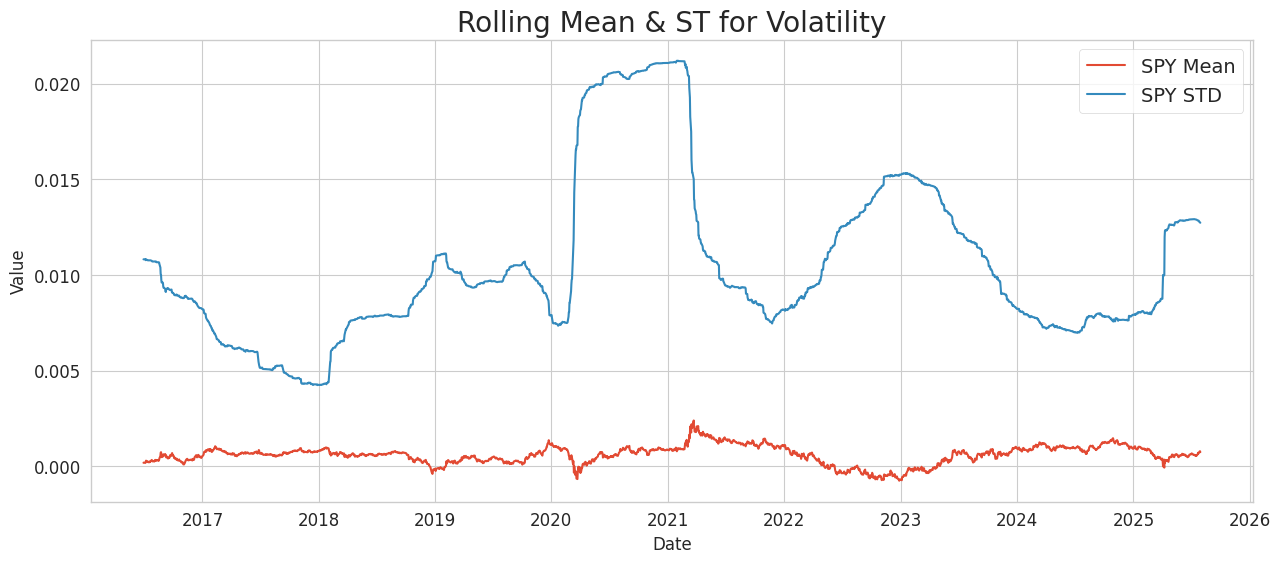

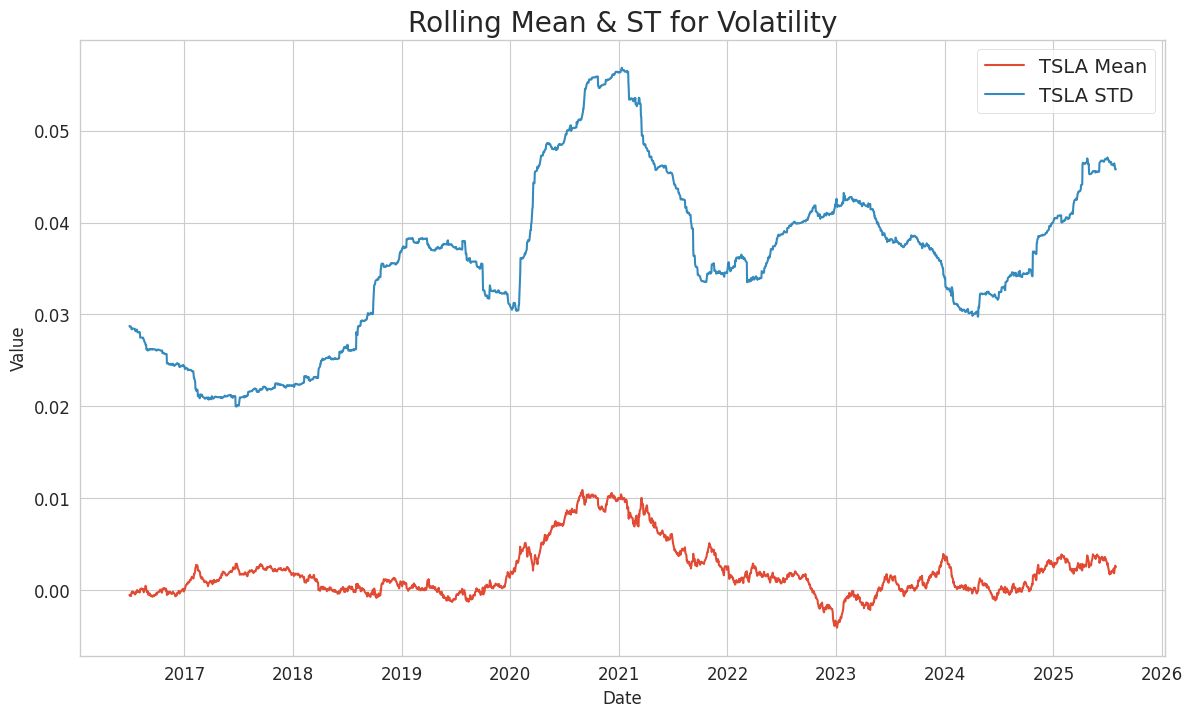

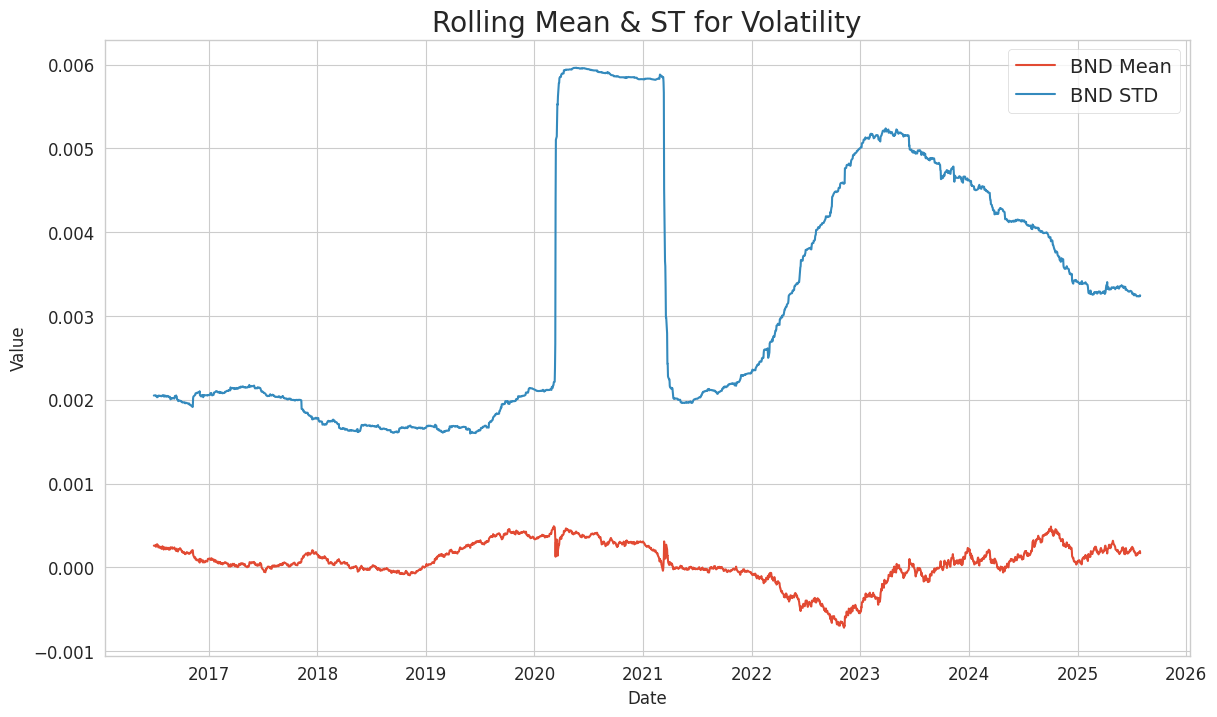

In [8]:
# Analyze volatility by calculating rolling means and standard deviations
return_mean=returns.rolling(window=252).mean()
return_std=returns.rolling(window=252).std()
print(return_mean)
print(return_std)
plt.figure(figsize=(15,6))
for asset in assets:
  plt.plot(return_mean[asset],label=f"{asset} Mean")
  plt.plot(return_std[asset],label=f"{asset} STD")
  plt.title('Rolling Mean & ST for Volatility')
  plt.xlabel('Date')
  plt.ylabel('Value')
  plt.legend()
  plt.show()



In [9]:
# Perform outlier detection to identify significant anomalies using z-score.
# Calculate z-scores for returns
z_scores = (returns - return_mean) /return_std
threshold = 3
# Detect outliers: boolean DataFrame with True where outlier
outliers = np.abs(z_scores) > threshold
for asset in assets:
    outlier_dates = returns.index[outliers[asset]]
    outlier_returns = returns.loc[outliers[asset], asset]
    for date, ret in zip(outlier_dates, outlier_returns):
        print(f"{date.date()} : Return = {ret:.2%}")


2017-05-17 : Return = -1.77%
2017-08-17 : Return = -1.56%
2018-02-02 : Return = -2.18%
2018-02-05 : Return = -4.18%
2018-02-06 : Return = 1.97%
2018-02-08 : Return = -3.75%
2018-03-22 : Return = -2.50%
2018-03-23 : Return = -2.13%
2018-03-26 : Return = 2.74%
2018-04-02 : Return = -2.16%
2018-04-06 : Return = -2.23%
2018-10-10 : Return = -3.17%
2018-10-24 : Return = -3.03%
2018-12-04 : Return = -3.24%
2018-12-26 : Return = 5.05%
2019-01-04 : Return = 3.35%
2019-08-05 : Return = -3.01%
2020-02-24 : Return = -3.32%
2020-02-25 : Return = -3.03%
2020-02-27 : Return = -4.49%
2020-03-02 : Return = 4.33%
2020-03-03 : Return = -2.86%
2020-03-04 : Return = 4.20%
2020-03-05 : Return = -3.32%
2020-03-09 : Return = -7.81%
2020-03-10 : Return = 5.17%
2020-03-11 : Return = -4.87%
2020-03-12 : Return = -9.57%
2020-03-13 : Return = 8.55%
2020-03-16 : Return = -10.94%
2020-03-17 : Return = 5.40%
2020-03-18 : Return = -5.06%
2020-03-24 : Return = 9.06%
2020-03-26 : Return = 5.84%
2020-04-06 : Return = 6.

## Seasonality and Trends:

In [16]:
# Perform a statistical test (e.g., Augmented Dickey-Fuller test)
for asset in assets:
  asset_price=prices[asset]
  asset_return=returns[asset]
  # Check for stationarity using Augmented Dickey-Fuller test
  def check_stationarity(timeseries):
    result=adfuller(timeseries)
    print("ADF statistics: ",result[0])
    print("p-value: ",result[1])
    for key,value in result[4].items():
      print(f"Critical value ({key}):",{value})
    if result[1]<=0.05:
      print("Result: The series is stationary (reject H0)")
    else:
      print("Result: The series is not stationary (fail to reject H0)")
  print(f"\nTesting stationarity of {asset} prices:")
  check_stationarity(asset_price)

  print(f"\nTesting stationarity of {asset} returns:")
  check_stationarity(asset_return)




Testing stationarity of SPY prices:
ADF statistics:  0.6908126335480996
p-value:  0.9896527252966039
Critical value (1%): {-3.4329424595562963}
Critical value (5%): {-2.862685339846278}
Critical value (10%): {-2.5673797079109892}
Result: The series is not stationary (fail to reject H0)

Testing stationarity of SPY returns:
ADF statistics:  -16.2643781858602
p-value:  3.539375986052469e-29
Critical value (1%): {-3.4329424595562963}
Critical value (5%): {-2.862685339846278}
Critical value (10%): {-2.5673797079109892}
Result: The series is stationary (reject H0)

Testing stationarity of TSLA prices:
ADF statistics:  -1.4188720053968278
p-value:  0.5731959514207221
Critical value (1%): {-3.4329610922579095}
Critical value (5%): {-2.8626935681060375}
Critical value (10%): {-2.567384088736619}
Result: The series is not stationary (fail to reject H0)

Testing stationarity of TSLA returns:
ADF statistics:  -34.68109047254196
p-value:  0.0
Critical value (1%): {-3.4329352851231945}
Critical va

In [14]:
# since the prices series is non stationary ,i apply differnce to the price
dif_prices=prices.diff().dropna()

## calculate foundational risk metrics like Value at Risk (VaR) and the Sharpe Ratio

In [18]:
# calculate foundational risk metrics like Value at Risk (VaR) and the Sharpe Ratio
confidence_level = 0.05

# Historical VaR (5th percentile)
VaR_95 = returns.quantile(confidence_level)
print(f"Historical Value at risk at 95% confidence: {VaR_95}")

# Historical Sharpe Ratio
sharpe_ratio = returns.mean()*252 / returns.std()*np.sqrt(252)
print(f"Historical Sharpe Ratio: {sharpe_ratio}")

Historical Value at risk at 95% confidence: Ticker
BND    -0.004900
SPY    -0.017195
TSLA   -0.054663
Name: 0.05, dtype: float64
Historical Sharpe Ratio: Ticker
BND      89.933528
SPY     200.106311
TSLA    196.141784
dtype: float64
